<h1><center>MPST: A Corpus of Movie Plot Synopses with Tags</center></h1>

In [162]:
# !pip install scikit-multilearn

import re
import os
import tqdm
import nltk
import sqlite3
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
# import xgboost as xgb
from nltk.corpus import words
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from itertools import combinations
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize
from scipy.sparse import coo_matrix, hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
# from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score,precision_score,recall_score,hamming_loss

%matplotlib inline
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")
stemmer = SnowballStemmer('english')

%autosave 120

[nltk_data] Downloading package punkt to /home/happy-
[nltk_data]     gargarin/Desktop/ocr/projet_5/venv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/happy-
[nltk_data]     gargarin/Desktop/ocr/projet_5/venv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/happy-
[nltk_data]     gargarin/Desktop/ocr/projet_5/venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Autosaving every 120 seconds


# # 1. BUSINESS PROBLEM

##### Description:

Wikipedia is the world's largest multilingual non-profit online encyclopedia with exclusively free content and no ads and IMDb is an online database of information related to films, television programs, including cast, production crew and personnel biographies, plot summaries, trivia, and fan reviews and ratings.

IMDB is something which every person use one way or another. Each month every new movie, television show is added to the imdb collection with every detail like plot summeries, cast and crew. while adding the information about the movies some time admins forget to add the tags this is where machine learning comes in to picture.

##### Problem Statement:

Suggest the tags based on the plot summeries given for the movies.

<b>Source:</b> 

1.https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

2.https://www.aclweb.org/anthology/L18-1274

## 1.2 Real World / Business Objectives and Constraints

1. Predict as many tags as possible with high precision and recall.
2. No strict latency constraints.

# 2. Machine Learning Problem

## 2.1 Data

### 2.1.1 Data Overview

All of the data is in 1 file: mpst_full_data.csv.

mpst.csv contains 6 columns: Id,title,plot_synopsis,tags, split, synopsis_source.

Size of mpst_ful_data.csv - 73MB

Number of rows in mpst_full_data.csv ~ 14K

##### Datafield Explaination

Dataset contains 14k rows. The columns in the table are:

Id - Unique identifier for each movie.

Title - The movie name.

plot_synopsis - The summary of the movie.

Tags - The tags associated with the movies.

split - consists the information about train,val,test.

synopsis_scorce - Information about where the plot information is taken.

## 2.2 Mapping RealWorld Problem toMachine Learning Problem
### 2.2.1 Type of Machine learning Problem
It is a multi-label classification problem

Multi-label Classification: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A plot for the movie on imdb might be about any of fiction, thiller, sci-fi at the same time or none of these.

### 2.2.2 Performence Metric
Micro-Averaged F1-Score (Mean F Score) : The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

'Micro f1 score': Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

# 3. EXPOLATORY DATA ANALYSIS:

## 3.1 LOADING DATA: 

In [163]:
data_no_dup = pd.read_csv("QueryResults.csv").rename(columns={"Tags": "tags"})
data_no_dup["tags"] = data_no_dup["tags"].str.lstrip('<').str.replace('<', ' ').str.replace('>', '')
data_no_dup.head()

Title  \
0  Android Studio : "Could not get unknown proper...   
1  How to mock history.push with the new React Ro...   
2             C#: Converting List of Chars to String   
3  Implementing efficient audit trail of record c...   
4  How to change the number of rows in the textar...   

                                                Body  \
0  <p>I am a newbie with Android Studio. I am try...   
1  <p>I am trying to mock <code>history.push</cod...   
2  <p>I'm solving a coding challenge on Coderbyte...   
3  <p>I have a quite common design problem: I nee...   
4  <p>I have a textarea with 5 lines. I want to s...   

                                                tags        Id  Score  \
0  java android android-studio gradle android-gra...  40420705      6   
1  reactjs react-router jestjs react-router-dom r...  58524183     53   
2                                          c# string  58524222     14   
3  python performance google-app-engine audit exp...   4417130      6   
4           javascript jquery textarea jquery-events   4417161     21   

   ViewCount  FavoriteCount  AnswerCount  
0      51645            0.0            3  
1      60110            0.0            3  
2      30960            NaN            1  
3       2075            0.0            1  
4      32115            0.0            3

In [164]:
#Learn SQL: https://www.w3schools.com/sql/default.asp
# start = datetime.now()
# if not os.path.isfile('mpst.db'):
#     disk_engine = create_engine('sqlite:///mpst.db')
#     start = dt.datetime.now()
#     chunksize = 15000
#     j = 0
#     index_start = 1
#     for df in pd.read_csv('mpst_full_data.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
#         df.index += index_start
#         j+=1
#         df.to_sql('mpst_full_data', disk_engine, if_exists='append')
#         index_start = df.index[-1] + 1
# else:
#     print("Database Already Exist.")
#
# print("Time taken to run this cell :", datetime.now() - start)

In [165]:
# # removing duplicates
# con = sqlite3.connect('mpst.db')
#
# data_no_dup = pd.read_sql_query('SELECT title,plot_synopsis,tags,split,synopsis_source,COUNT(*) as cnt_dup FROM mpst_full_data GROUP BY title', con)
# data_no_dup.shape
#
# con.close()

In [166]:
data_no_dup.head()

Title  \
0  Android Studio : "Could not get unknown proper...   
1  How to mock history.push with the new React Ro...   
2             C#: Converting List of Chars to String   
3  Implementing efficient audit trail of record c...   
4  How to change the number of rows in the textar...   

                                                Body  \
0  <p>I am a newbie with Android Studio. I am try...   
1  <p>I am trying to mock <code>history.push</cod...   
2  <p>I'm solving a coding challenge on Coderbyte...   
3  <p>I have a quite common design problem: I nee...   
4  <p>I have a textarea with 5 lines. I want to s...   

                                                tags        Id  Score  \
0  java android android-studio gradle android-gra...  40420705      6   
1  reactjs react-router jestjs react-router-dom r...  58524183     53   
2                                          c# string  58524222     14   
3  python performance google-app-engine audit exp...   4417130      6   
4           javascript jquery textarea jquery-events   4417161     21   

   ViewCount  FavoriteCount  AnswerCount  
0      51645            0.0            3  
1      60110            0.0            3  
2      30960            NaN            1  
3       2075            0.0            1  
4      32115            0.0            3

## 3.2 Tag Analysis:

In [167]:
data_no_dup["tag_count"] = data_no_dup["tags"].apply(lambda text: len(str(text).split(" ")))
data_no_dup.head()

Title  \
0  Android Studio : "Could not get unknown proper...   
1  How to mock history.push with the new React Ro...   
2             C#: Converting List of Chars to String   
3  Implementing efficient audit trail of record c...   
4  How to change the number of rows in the textar...   

                                                Body  \
0  <p>I am a newbie with Android Studio. I am try...   
1  <p>I am trying to mock <code>history.push</cod...   
2  <p>I'm solving a coding challenge on Coderbyte...   
3  <p>I have a quite common design problem: I nee...   
4  <p>I have a textarea with 5 lines. I want to s...   

                                                tags        Id  Score  \
0  java android android-studio gradle android-gra...  40420705      6   
1  reactjs react-router jestjs react-router-dom r...  58524183     53   
2                                          c# string  58524222     14   
3  python performance google-app-engine audit exp...   4417130      6   
4           javascript jquery textarea jquery-events   4417161     21   

   ViewCount  FavoriteCount  AnswerCount  tag_count  
0      51645            0.0            3          5  
1      60110            0.0            3          5  
2      30960            NaN            1          2  
3       2075            0.0            1          5  
4      32115            0.0            3          4

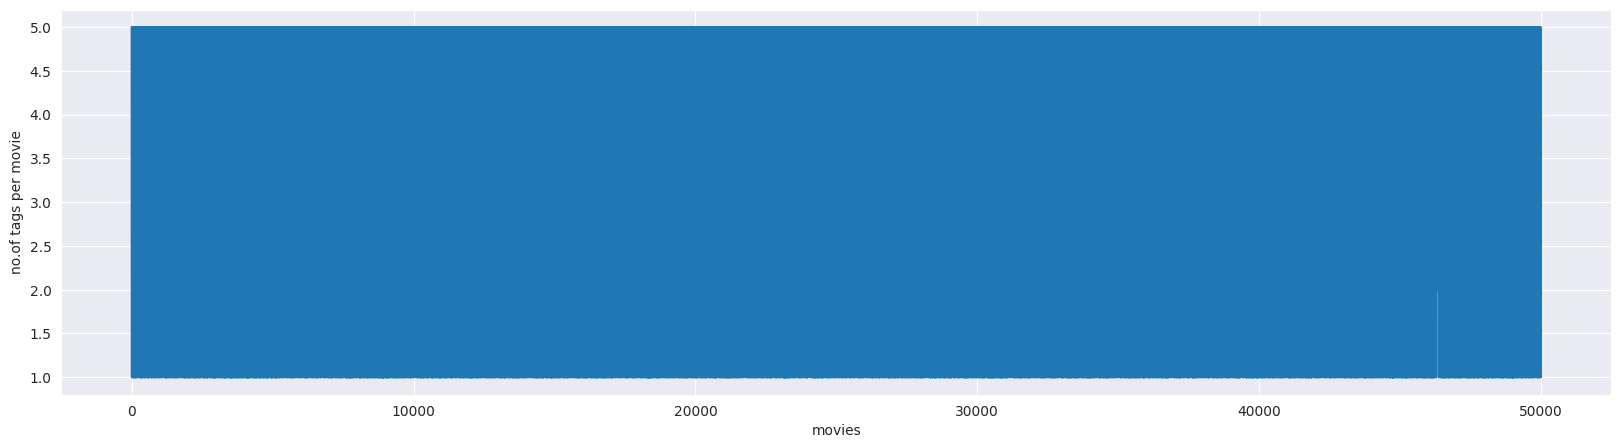

In [168]:
plt.figure(figsize=(20,5))
plt.plot(data_no_dup["tag_count"])
plt.xlabel('movies')
plt.ylabel("no.of tags per movie")
plt.show()

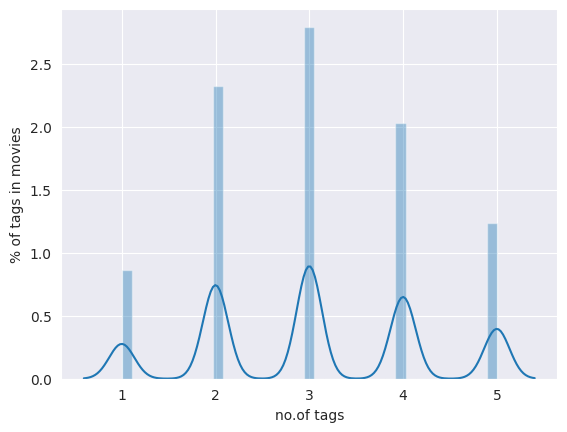

In [169]:
sns.distplot(data_no_dup["tag_count"])
plt.ylabel('% of tags in movies')
plt.xlabel('no.of tags')
plt.show()

In [170]:
data_no_dup["tag_count"].value_counts()

3    15110
2    12559
4    10972
5     6689
1     4670
Name: tag_count, dtype: int64

In [171]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(" ") )
tag_vect = vectorizer.fit_transform(data_no_dup["tags"])

In [172]:
print("Number of data points :", tag_vect.shape[0])
print("Number of unique tags :", tag_vect.shape[1])

Number of data points : 50000
Number of unique tags : 12989


In [173]:
tags = vectorizer.get_feature_names_out()
print("unique tags: \n", tags[:])

unique tags: 
 ['.app' '.class-file' '.emf' ... 'zurb-foundation' 'zurb-joyride' 'zxing']


In [174]:
#zipping tags and tags_count into one list
freqs = tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

[('.app', 1), ('.class-file', 1), ('.emf', 1), ('.htaccess', 58), ('.htpasswd', 2), ('.net', 2603), ('.net-1.1', 1), ('.net-2.0', 49), ('.net-3.0', 2), ('.net-3.5', 84), ('.net-4.0', 22), ('.net-4.0-beta-2', 1), ('.net-4.5', 13), ('.net-4.6', 1), ('.net-4.6.1', 1), ('.net-4.7.2', 1), ('.net-5', 2), ('.net-6.0', 1), ('.net-assembly', 11), ('.net-attributes', 2), ('.net-core', 78), ('.net-core-3.0', 3), ('.net-core-rc2', 4), ('.net-micro-framework', 1), ('.net-native', 1), ('.net-reflector', 1), ('.net-services', 1), ('.net-standard', 2), ('.refresh', 1), ('16-bit', 3), ('256color', 1), ('2d', 18), ('2d-games', 3), ('3-tier', 1), ('32-bit', 11), ('32bit-64bit', 11), ('360-panorama-viewer', 1), ('3d', 52), ('3d-modelling', 1), ('3d-rendering', 2), ('3nf', 1), ('4d-database', 1), ('64-bit', 65), ('68000', 1), ('7zip', 6), ('8-bit', 1), ('8051', 1), ('960.gs', 1), ('a-star', 6), ('aac', 1), ('aapt', 4), ('aapt2', 1), ('aar', 2), ('ab-testing', 1), ('abac', 1), ('abaddressbook', 1), ('abap',

In [175]:
tag_counts = pd.DataFrame(result,columns=['tag','tag_counts'])
tag_counts.head()

tag  tag_counts
0         .app           1
1  .class-file           1
2         .emf           1
3    .htaccess          58
4    .htpasswd           2

In [176]:
tag_counts['tag_counts'].describe()

count    12989.000000
mean        11.736931
std         98.125506
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       5353.000000
Name: tag_counts, dtype: float64

In [177]:
tag_counts_sorted = tag_counts.sort_values(['tag_counts'], ascending=False)
tag_counts = tag_counts_sorted['tag_counts'].values

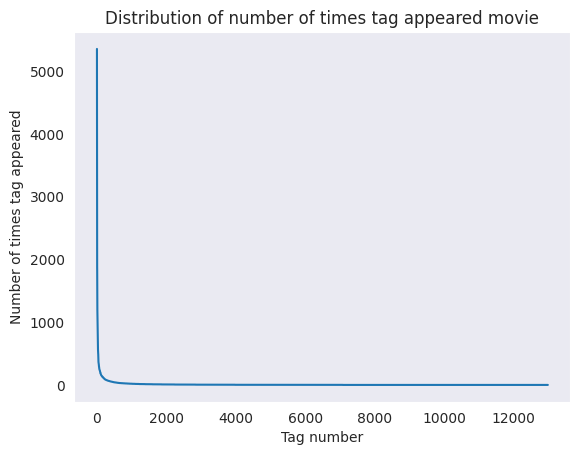

In [178]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared movie")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

In [179]:
tag_synop_count = tag_vect.sum(axis=1).tolist()
#Converting each value in the 'tag_synop_count' to integer.
tag_synop_count=[int(j) for i in tag_synop_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_synop_count)))

print( "Maximum number of tags per movie: %d"%max(tag_synop_count))
print( "Minimum number of tags per movie: %d"%min(tag_synop_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_synop_count)*1.0)/len(tag_synop_count)))

We have total 50000 datapoints.
Maximum number of tags per movie: 5
Minimum number of tags per movie: 1
Avg. number of tags per movie: 3.049020


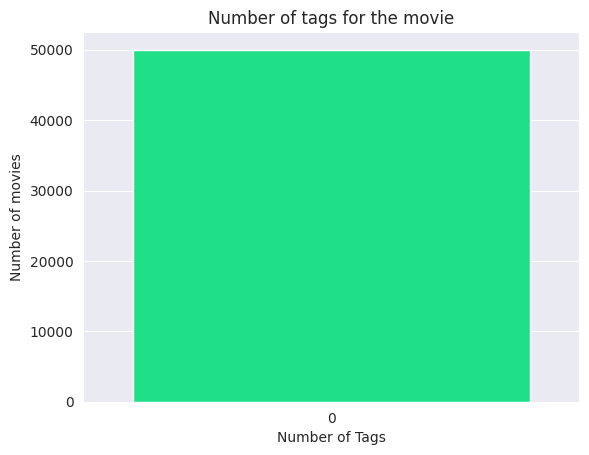

In [180]:
sns.countplot(tag_synop_count, palette='gist_rainbow')
plt.title("Number of tags for the movie")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

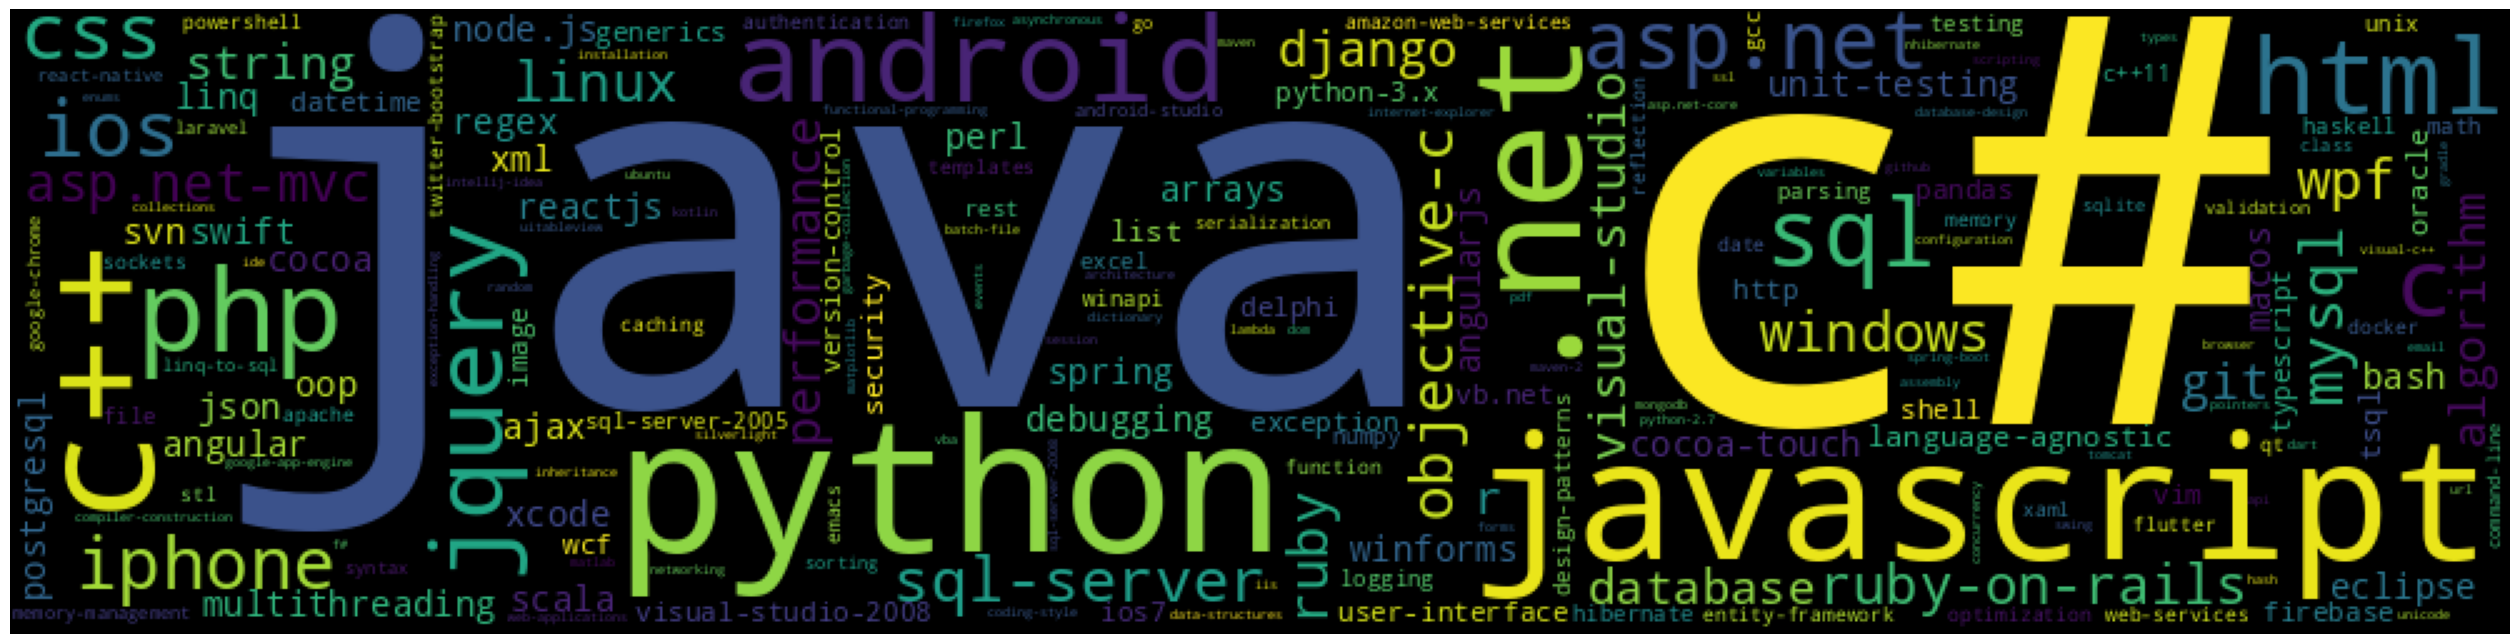

In [181]:
result = dict(zip(tags, freqs))
words = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black', width = 1000, height = 250,).generate_from_frequencies(words)

fig = plt.figure(figsize=(25, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

In [182]:
def tags_to_choose(n):
    t = tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=tag_vect[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

questions_explained = []
total_tags=tag_vect.shape[1]
total_qs=data_no_dup.shape[0]
for i in range(total_tags):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

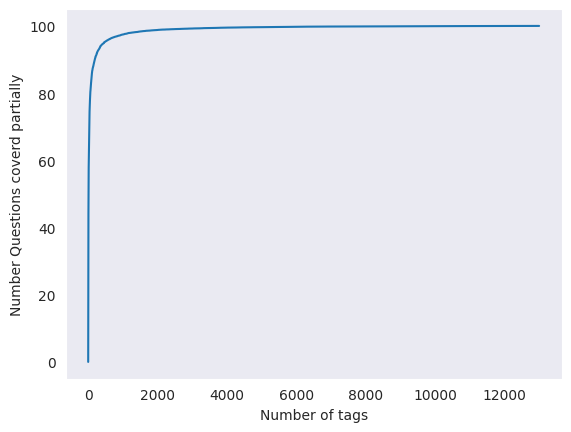

In [183]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

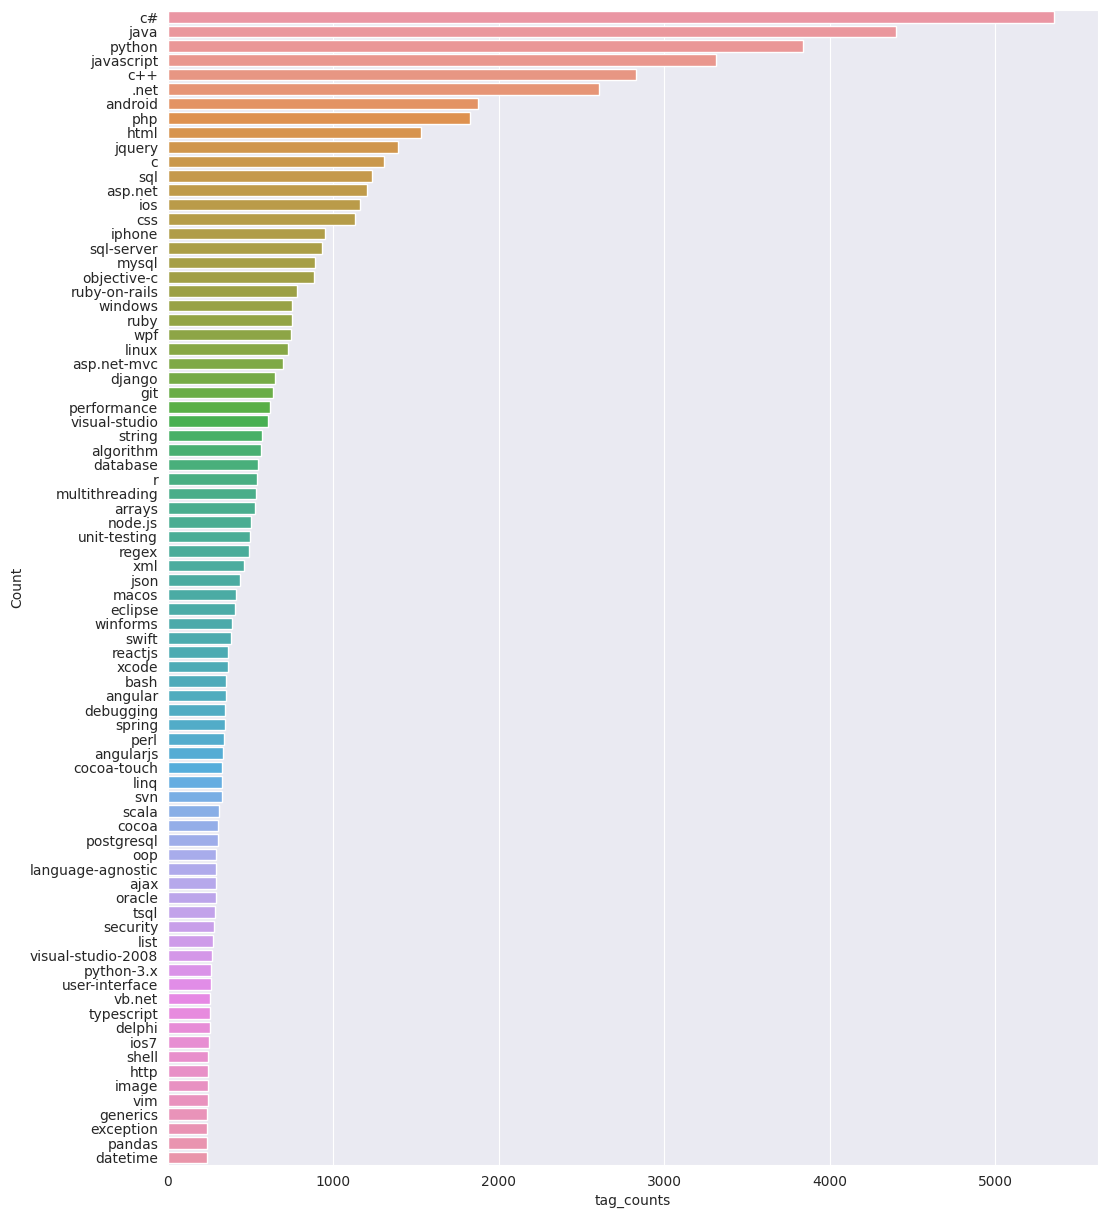

In [184]:
p = tag_counts_sorted.nlargest(columns="tag_counts",n=80) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=p, x= "tag_counts", y = "tag")
ax.set(ylabel = 'Count')
plt.show()

## 3.3 Question Analysis

In [185]:
data_no_dup["synopsis_count"] = data_no_dup["Title"].apply(lambda text: len(str(text).split(" ")))
data_no_dup.head()

Title  \
0  Android Studio : "Could not get unknown proper...   
1  How to mock history.push with the new React Ro...   
2             C#: Converting List of Chars to String   
3  Implementing efficient audit trail of record c...   
4  How to change the number of rows in the textar...   

                                                Body  \
0  <p>I am a newbie with Android Studio. I am try...   
1  <p>I am trying to mock <code>history.push</cod...   
2  <p>I'm solving a coding challenge on Coderbyte...   
3  <p>I have a quite common design problem: I nee...   
4  <p>I have a textarea with 5 lines. I want to s...   

                                                tags        Id  Score  \
0  java android android-studio gradle android-gra...  40420705      6   
1  reactjs react-router jestjs react-router-dom r...  58524183     53   
2                                          c# string  58524222     14   
3  python performance google-app-engine audit exp...   4417130      6   
4           javascript jquery textarea jquery-events   4417161     21   

   ViewCount  FavoriteCount  AnswerCount  tag_count  synopsis_count  
0      51645            0.0            3          5              14  
1      60110            0.0            3          5              12  
2      30960            NaN            1          2               7  
3       2075            0.0            1          5              14  
4      32115            0.0            3          4              12

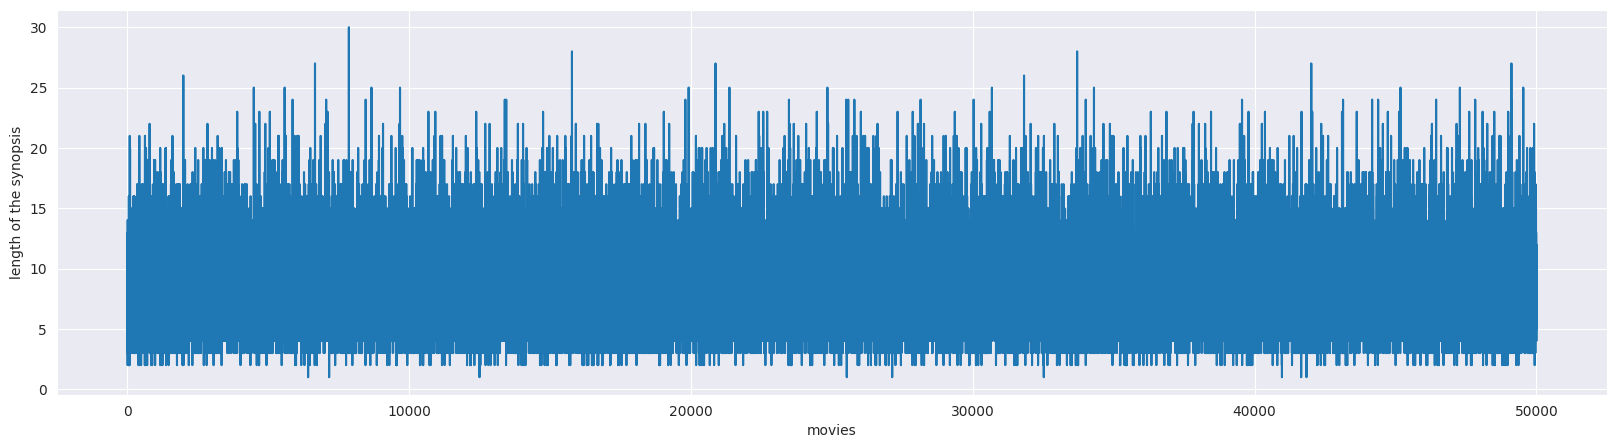

In [186]:
plt.figure(figsize=(20,5))
plt.plot(data_no_dup['synopsis_count'])
plt.xlabel("movies")
plt.ylabel("length of the synopsis")
plt.show()

In [187]:
data_no_dup["synopsis_sent_count"] = data_no_dup["Title"].apply(lambda text: len(str(text).split(".")))
data_no_dup.head()

Title  \
0  Android Studio : "Could not get unknown proper...   
1  How to mock history.push with the new React Ro...   
2             C#: Converting List of Chars to String   
3  Implementing efficient audit trail of record c...   
4  How to change the number of rows in the textar...   

                                                Body  \
0  <p>I am a newbie with Android Studio. I am try...   
1  <p>I am trying to mock <code>history.push</cod...   
2  <p>I'm solving a coding challenge on Coderbyte...   
3  <p>I have a quite common design problem: I nee...   
4  <p>I have a textarea with 5 lines. I want to s...   

                                                tags        Id  Score  \
0  java android android-studio gradle android-gra...  40420705      6   
1  reactjs react-router jestjs react-router-dom r...  58524183     53   
2                                          c# string  58524222     14   
3  python performance google-app-engine audit exp...   4417130      6   
4           javascript jquery textarea jquery-events   4417161     21   

   ViewCount  FavoriteCount  AnswerCount  tag_count  synopsis_count  \
0      51645            0.0            3          5              14   
1      60110            0.0            3          5              12   
2      30960            NaN            1          2               7   
3       2075            0.0            1          5              14   
4      32115            0.0            3          4              12   

   synopsis_sent_count  
0                    4  
1                    2  
2                    1  
3                    1  
4                    1

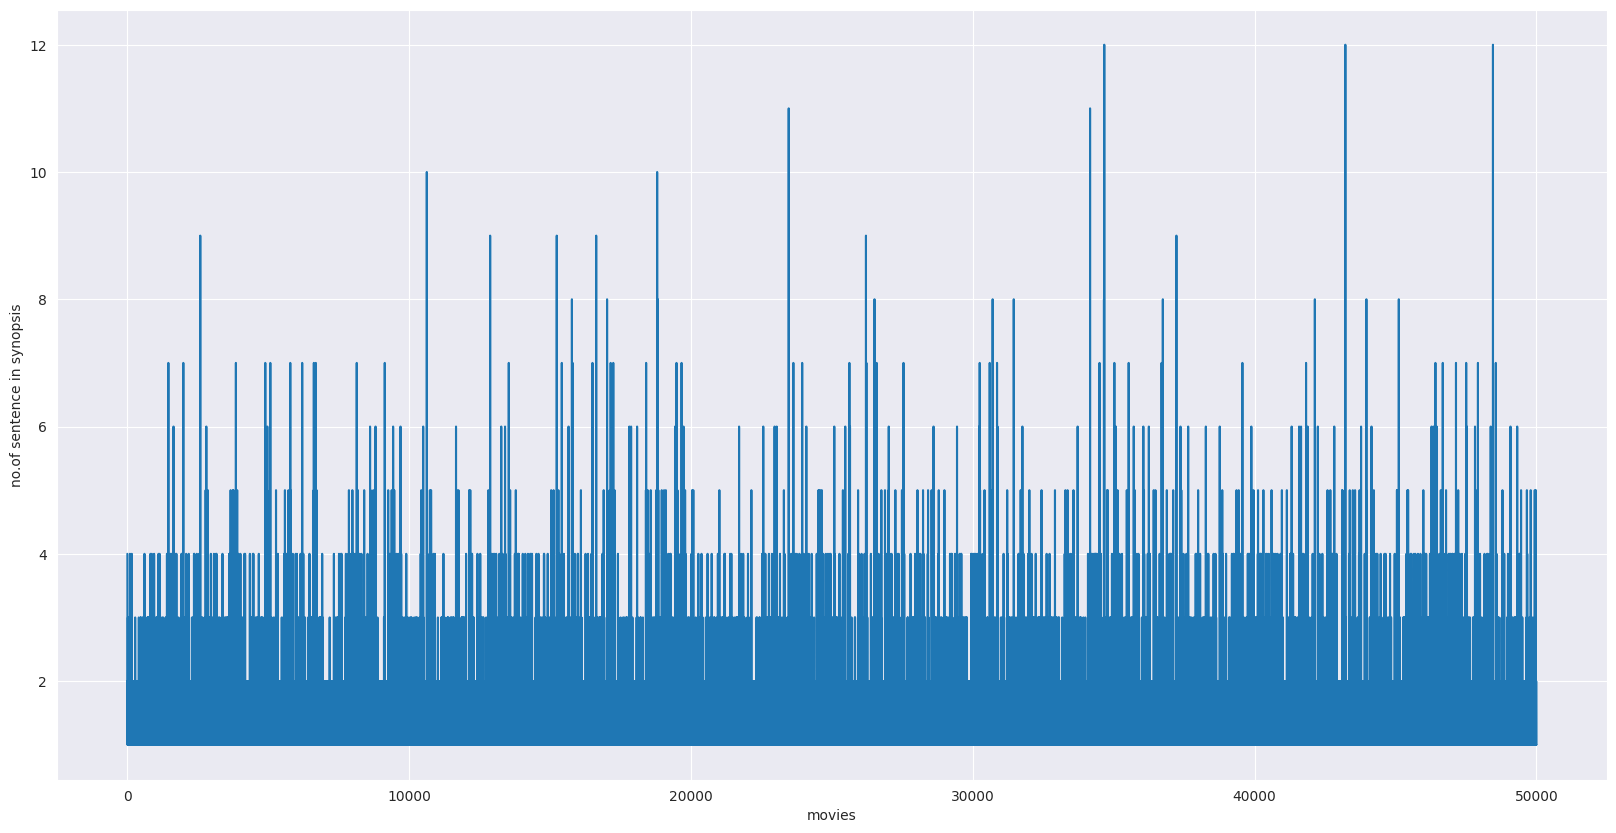

In [188]:
plt.figure(figsize=(20,10))
plt.plot(data_no_dup['synopsis_sent_count'])
plt.xlabel("movies")
plt.ylabel("no.of sentence in synopsis")
plt.show()

## 3.4 Source Analysis:

In [189]:
# most of the data is taken from wikipedia
# sns.countplot(data_no_dup['synopsis_source'])
# plt.show()

In [190]:
# sns.countplot(data_no_dup['split'])
# plt.show()

## 3.5 Data Cleaning:

In [191]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [192]:
stopwords = set(stopwords.words('english'))

In [193]:
sno = nltk.stem.SnowballStemmer('english')

In [194]:
lemmatizer = WordNetLemmatizer()

In [195]:
preprocessed_synop = []
for sentance in tqdm(data_no_dup['Title'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    stemmed_sentence = []
    for e in sentance.split():
        if e.lower() not in stopwords:
            s=(sno.stem(lemmatizer.lemmatize(e.lower()))).encode('utf8')#lemitizing and stemming each word
            stemmed_sentence.append(s)
    sentance = b' '.join(stemmed_sentence)
    preprocessed_synop.append(sentance)
    
data_no_dup['CleanedSynopsis']=preprocessed_synop #adding a column of CleanedText which displays the data after pre-processing of the review 
data_no_dup['CleanedSynopsis']=data_no_dup['CleanedSynopsis'].str.decode("utf-8")

100%|██████████| 50000/50000 [00:09<00:00, 5435.12it/s]


In [196]:
data_no_dup["CleanedSynopsis"][0]

'android studio could get unknown properti version name project type org gradl api project'

In [197]:
#saving cleaned data to csv file
data_no_dup.to_csv('cleaned_data.csv',index=False)

In [198]:
data=data_no_dup

In [199]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(" ") )
tag_vect = vectorizer.fit_transform(data_no_dup["tags"])

print("Number of data points :", tag_vect.shape[0])
print("Number of unique tags :", tag_vect.shape[1])

tag = vectorizer.get_feature_names_out()
print("unique tags: \n", tag[:])

Number of data points : 50000
Number of unique tags : 12989
unique tags: 
 ['.app' '.class-file' '.emf' ... 'zurb-foundation' 'zurb-joyride' 'zxing']


In [202]:
tag[:]

array(['.app', '.class-file', '.emf', ..., 'zurb-foundation',
       'zurb-joyride', 'zxing'], dtype=object)

In [200]:
#converting tags sparse matrix into dataframe
tags=pd.DataFrame(tag_vect.toarray())

In [201]:
tags.columns = ['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war',\
                'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing',\
                'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark',\
                'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic',\
                'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity',\
                'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction',\
                'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer',\
                'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid',\
                'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']
tags.head()

ValueError: Length mismatch: Expected axis has 12989 elements, new values have 71 elements

In [ ]:
#concatenating data and tags dataframes
data_with_all_tags = pd.concat([data,tags],axis=1)

In [ ]:
#After concatenating two data frames their is a possiblity of null values.
#checking for null values
#True:null values are present
#False:null values are not present
data_with_all_tags.isnull().values.any()

In [ ]:
data_with_all_tags.head()

In [ ]:
data_with_all_tags.to_csv('data_with_all_tags.csv',index=False)

In [ ]:
conn = sqlite3.connect('data.db')
data_with_all_tags.to_sql('data', conn, if_exists='replace', index=False)
train = pd.read_sql("Select * From data where split = 'train' OR split='val'",conn)
test =  pd.read_sql("Select * From data where split = 'test'",conn)
conn.close()

# Train tag analysis

In [ ]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(" ") )
train_tag_vect = vectorizer.fit_transform(train["tags"])

print("Number of data points :", train_tag_vect.shape[0])
print("Number of unique tags :", train_tag_vect.shape[1])

tags = vectorizer.get_feature_names()

#zipping tags and tags_count into one list
freqs = train_tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

In [ ]:
def tags_to_choose(n):
    t = train_tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=train_tag_vect[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

questions_explained = []
total_tags=train_tag_vect.shape[1]
total_qs=data.shape[0]
for i in range(total_tags):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

print("with ",5,"tags we are covering ",questions_explained[5],"% of movies")
print("with ",10,"tags we are covering ",questions_explained[10],"% of movies")
print("with ",18,"tags we are covering ",questions_explained[18],"% of movies")
print("with ",20,"tags we are covering ",questions_explained[20],"% of movies")
print("with ",26,"tags we are covering ",questions_explained[26],"% of movies")
print("with ",30,"tags we are covering ",questions_explained[30],"% of movies")
print("with ",35,"tags we are covering ",questions_explained[35],"% of movies")
print("with ",40,"tags we are covering ",questions_explained[40],"% of movies")
print("with ",50,"tags we are covering ",questions_explained[50],"% of movies")
print("with ",60,"tags we are covering ",questions_explained[60],"% of movies")

# Test tag analysis

In [ ]:
vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(", ") )
test_tag_vect = vectorizer.fit_transform(test["tags"])

print("Number of data points :", test_tag_vect.shape[0])
print("Number of unique tags :", test_tag_vect.shape[1])

tags = vectorizer.get_feature_names()

#zipping tags and tags_count into one list
freqs = test_tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

In [ ]:
def tags_to_choose(n):
    t = test_tag_vect.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=test_tag_vect[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

questions_explained = []
total_tags=test_tag_vect.shape[1]
total_qs=data.shape[0]
for i in range(total_tags):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

print("with ",5,"tags we are covering ",questions_explained[5],"% of movies")
print("with ",10,"tags we are covering ",questions_explained[10],"% of movies")
print("with ",18,"tags we are covering ",questions_explained[18],"% of movies")
print("with ",20,"tags we are covering ",questions_explained[20],"% of movies")
print("with ",26,"tags we are covering ",questions_explained[26],"% of movies")
print("with ",30,"tags we are covering ",questions_explained[30],"% of movies")
print("with ",35,"tags we are covering ",questions_explained[35],"% of movies")
print("with ",40,"tags we are covering ",questions_explained[40],"% of movies")
print("with ",50,"tags we are covering ",questions_explained[50],"% of movies")
print("with ",60,"tags we are covering ",questions_explained[60],"% of movies")

##### Observaton:

Looks like their is some inconsistancy of tags in train and test with respect to movies. 